In [2]:
from nansat import Nansat, Domain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from scipy.ndimage.filters import gaussian_filter, median_filter

In [36]:
# Domain
# <pixel_size> spatrial resolution of each pixel in meters. 
# Based on characteristics of sentinel2a. Min: 10 m; Mean: 20 m; Max: 60 m;
# To get more about sentinel2a bands see:
# https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric
pixel_size = 60
# <x_resol> and <y_resol> are resolution of image in kilometers converted 
# to chused resolution of sentinel2a image (see hiyer)
x_resol, y_resol = 122 * (1000 / pixel_size), 78 * (1000 / pixel_size)
# <sbd_dom> is domain which covers Sandy Bear Dunes Region
# For overview region on a map see: https://github.com/korvinos/michigan/blob/master/michigan.geojson
sbd_dom = Domain('+proj=latlong +datum=WGS84 +ellps=WGS84 +no_defs', '-lle -86.3 44.6 -85.2 45.3 -ts %s %s' % (x_resol, y_resol))

# Dataset & paths
# <sfile_root> is a path to rood directory of sentinel2 images storage
sfile_root = '/nfs0/data_ocolor/michigan/michigan1617/clear_data/sentinel2/'
# <sfiles_list> is a list of products in the root directory 
sfiles_list = np.array(glob.glob(os.path.join(sfile_root, '*')))
# <save_path> is a path to accumulation of reprojected files
save_path = '/nfs0/data_ocolor/michigan/michigan1617/reprojected_data/sentinel2/'
# postfix to identification of reprojected files
postfix = '_reprojected.nc'


# Initial infarmation about data structure
# <granules> is list of granules covers Sandy Bear Dunes region.
# To get more information about granules see: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types
granules = ['16TER', '16TFR', 
            '16TEQ', '16TFQ']

BANDS = {
    '01':{ 'wavelength': 443, 'resolution': 60 },
    '02':{ 'wavelength': 490, 'resolution': 10 },
    '03':{ 'wavelength': 560, 'resolution': 10 },
    '04':{ 'wavelength': 665, 'resolution': 10 },
    '05':{ 'wavelength': 705, 'resolution': 20 },
    '06':{ 'wavelength': 740, 'resolution': 20 },
    '07':{ 'wavelength': 783, 'resolution': 20 },
    '08':{ 'wavelength': 842, 'resolution': 10 },
#    '8A':{ 'wavelength': 865, 'resolution': 20 },
    '09':{ 'wavelength': 945, 'resolution': 60 },
    '10':{ 'wavelength': 1375, 'resolution': 60 },
    '11':{ 'wavelength': 1610, 'resolution': 20 },
    '12':{ 'wavelength': 2190, 'resolution': 20 }
    }

In [38]:
def stich(band):
    global gdirs, n_obj
    print('Band:', band)
    # Generate 2d array which will have shape like <d> and filled by nan
    bandArray = np.zeros(d.shape()) + np.nan
    for gdir in gdirs:
        bfile = glob.glob(os.path.join(gdir, 'IMG_DATA', '*_B%s.jp2' % band))[0]
        n = Nansat(bfile)
        # Reprojection of data according to domain; eResampleAlg 1 is Bilinear
        n.reproject(d, eResampleAlg=1, addmask=False)
        # Get data array from nansat object 
        bdata = n[1] 
        bandArray[bdata > 0] = bdata[bdata > 0]
    
    n_obj.add_band(bandArray, parameters={'name': 'Rrs_%s' % BANDS[band]['wavelength']})

ifile = sfiles_list[]
gdirs = []
for granule in granules:
    gdirs += sorted(glob.glob(os.path.join(ifile, 'GRANULE', '*_T%s_*' % granule)))

# get lon/lat limits
# Lists for accumulation of lon/lat values from each granule
lons = []
lats = []
for gdir in gdirs:
    # Find absolute path to relevant granule
    b0file = glob.glob(os.path.join(gdir, 'IMG_DATA', '*_B01.jp2'))[0]
    # Get granule by nansat 
    n = Nansat(b0file)
    lon, lat = n.get_corners()
   
    # Add min/max values of long and lat to list
    lons += list(lon)
    lats += list(lat)

# Create domain according to max and min values of lon and lat
d = Domain(n.vrt.get_projection(), '-lle %f %f %f %f -tr 60 60' % (
            min(lons), min(lats), max(lons), max(lats)))
print('Domain created')

# Create base nansat object which domain covers all four <granules>
bands = sorted(BANDS.keys())[0:11]
n_obj = Nansat(domain=d)
stich = np.vectorize(stich)
stich(bands)
n_obj.reproject(sbd_dom)
n_obj.export(os.path.join(save_path, os.path.split(ifile)[1] + postfix))

IndexError: index 5 is out of bounds for axis 0 with size 5

In [40]:
!!ls /nfs0/data_ocolor/michigan/michigan1617/reprojected_data/sentinel2/

['S2A_OPER_PRD_MSIL1C_PDMC_20160309T031011_R126_V20160307T164311_20160307T164311.SAFE_reprojected.nc',
 'S2A_OPER_PRD_MSIL1C_PDMC_20160509T203209_R126_V20160506T164935_20160506T164935.SAFE_reprojected.nc',
 'S2A_OPER_PRD_MSIL1C_PDMC_20160705T215730_R126_V20160705T164320_20160705T164320.SAFE_reprojected.nc',
 'S2A_OPER_PRD_MSIL1C_PDMC_20160726T134643_R126_V20160725T164911_20160725T164911.SAFE_reprojected.nc',
 'S2A_OPER_PRD_MSIL1C_PDMC_20160815T014006_R126_V20160814T164322_20160814T164320.SAFE_reprojected.nc']

<IPython.core.display.Javascript object>


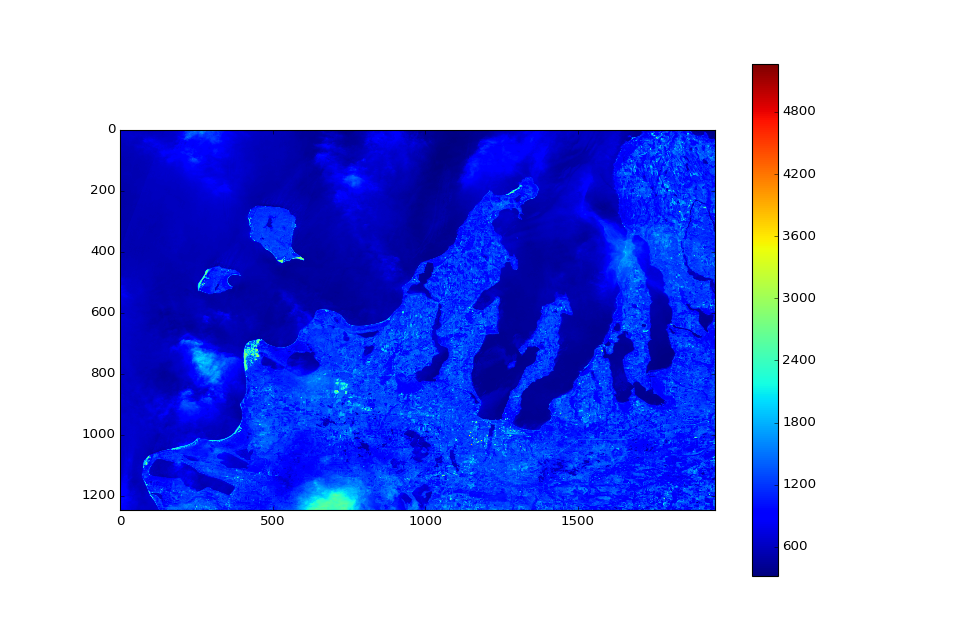

<bound method Nansat.bands of ----------------------------------------
/nfs0/data_ocolor/michigan/michigan1617/reprojected_data/sentinel2/S2A_OPER_PRD_MSIL1C_PDMC_20160509T203209_R126_V20160506T164935_20160506T164935.SAFE_reprojected.nc
----------------------------------------
Mapper: generic
----------------------------------------
Band : 1 Rrs_443
  _FillValue: 9.969209968386869e+36
  grid_mapping: crs
  name: Rrs_443
  dataType: 7
  long_name: GDAL Band Number 1
  SourceFilename: NETCDF:"/nfs0/data_ocolor/michigan/michigan1617/reprojected_data/sentinel2/S2A_OPER_PRD_MSIL1C_PDMC_20160509T203209_R126_V20160506T164935_20160506T164935.SAFE_reprojected.nc":Rrs_4431
  SourceBand: 1
  wkv: 
Band : 2 Rrs_443_000
  _FillValue: 9.969209968386869e+36
  name: Rrs_443_000
  dataType: 7
  long_name: GDAL Band Number 2
  SourceFilename: NETCDF:"/nfs0/data_ocolor/michigan/michigan1617/reprojected_data/sentinel2/S2A_OPER_PRD_MSIL1C_PDMC_20160509T203209_R126_V20160506T164935_20160506T164935.SAFE_repr

In [47]:
%matplotlib nbagg

n = Nansat('/data/')
n = Nansat('/nfs0/data_ocolor/michigan/michigan1617/reprojected_data/sentinel2/S2A_OPER_PRD_MSIL1C_PDMC_20160509T203209_R126_V20160506T164935_20160506T164935.SAFE_reprojected.nc')
plt.figure(figsize=(12,8))
print n.bands
plt.imshow(n[6])
plt.colorbar()
plt.show()